## Vehicle Detection Project

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [26]:
import glob
import time
import pickle
import cv2
import numpy as np
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import argparse
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
print("Imported required libraries!")

Imported required libraries!


The scikit-image package has a built in function to extract Histogram of Oriented Gradient features. The documentation for this function can be found here and a brief explanation of the algorithm and tutorial can be found here.

The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.

The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional power law or "gamma" normalization scheme set by the flag transform_sqrt. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

### Resize, Create histogram, Extract features

Resizes an image to reduce a number of features.
Creates a feature based on histogram of the image.
Converts an image into a feature vector that later can fed to a classifier.

In [3]:
def bin_spatial(img, size=(32, 32)):
    '''
    Define a function to compute binned color features
    '''
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 1)):
    '''
    Define a function to compute color histogram features
    NEED TO CHANGE bins_range if reading .png files with mpimg!
    Compute the histogram of the color channels separately
    '''
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Define a function to extract features from a single image window
    This function is very similar to extract_features()
    just for a single image rather than list of images
    ''' 
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Define a function to extract features from a list of images
    Have this function call bin_spatial() and color_hist()
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)

        feature =  single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(feature)
    # Return list of feature vectors
    return features

### Linear Support Vector Classification.
Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.
This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

```
class sklearn.svm.LinearSVC(penalty=’l2’, loss=’squared_hinge’, dual=True, tol=0.0001, C=1.0, multi_class=’ovr’, fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)[source]
```

In [7]:
def import_images():
    cars = glob.glob('./data/vehicles/**/*.png')
    notcars = glob.glob('./data/non-vehicles/**/*.png')
    num_of_car_images = len(cars)
    num_of_notcar_images = len(cars)

    print('Number of Car images = {}'.format(num_of_car_images))
    print('Number of Not-Car images = {}'.format(num_of_notcar_images))
    return cars, notcars

def train_and_save(color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2,
        hog_channel='ALL', spatial_size=(16, 16), hist_bins=32, spatial_feat=True,
        hist_feat=True, hog_feat=True):
    cars, notcars = import_images()

    print('Extracting Features...')

    start = time.time()

    car_features = extract_features(cars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    end = time.time()

    print('{:.2f} Seconds to extract features'.format(end - start))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = {:.4f}'.format(svc.score(X_test, y_test)))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

    dist_pickle = {}
    dist_pickle["color_space"] = color_space
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hog_channel"] = hog_channel
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["spatial_feat"] = spatial_feat
    dist_pickle["hist_feat"] = hist_feat
    dist_pickle["hog_feat"] = hog_feat

    with open("data/svc_pickle.p", "wb") as f:
        pickle.dump(dist_pickle, f)

train_and_save()

Number of Car images = 8792
Number of Not-Car images = 8792
Extracting Features...
120.99 Seconds to extract features
('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 6156)
(7.0, 'Seconds to train SVC...')
Test Accuracy of SVC = 0.9921
('SVC predicts: ', array([ 0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.]))
('For these', 10, 'labels: ', array([ 0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.]))
(0.0017, 'Seconds to predict', 10, 'labels with SVC')


In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [9]:
def convert_color(img, conv='BGR2YCR_CB'):
    if conv == 'BGR2YCR_CB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCR_CB')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [10]:
def import_data():
    return pickle.load(open("data/svc_pickle.p", "rb" ))
    
def process_image(image):
    window_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    dist_pickle = import_data()
    color_space = dist_pickle["color_space"]
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hog_channel = dist_pickle["hog_channel"]
    hist_bins = dist_pickle["hist_bins"]
    spatial_feat = dist_pickle["spatial_feat"]
    hist_feat = dist_pickle["hist_feat"]
    hog_feat = dist_pickle["hog_feat"]

    x_start_stop = [None, None]
    xy_overlap = (0.75, 0.75)

    y_start_stops = [[400, 645], [400, 600], [400, 550]]
    xy_windows = [(128, 128), (96, 96), (64, 64)]

    windows = []

    for y_start_stop, xy_window in zip(y_start_stops, xy_windows):
        windows.extend(slide_window(image, x_start_stop, y_start_stop, xy_window, xy_overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler,
                        color_space='YCrCb', spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(window_image), labels)

    return draw_img

In [11]:
# Detect cars in project video and save output
test_output = 'test_video_output.mp4'
clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [03:04<00:04,  4.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [12]:
# Detect cars in project video and save output
test_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [1:42:56<00:04,  4.95s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



## Print vizuals of the training dataset

Number of Car images = 8792
Number of Not-Car images = 8792


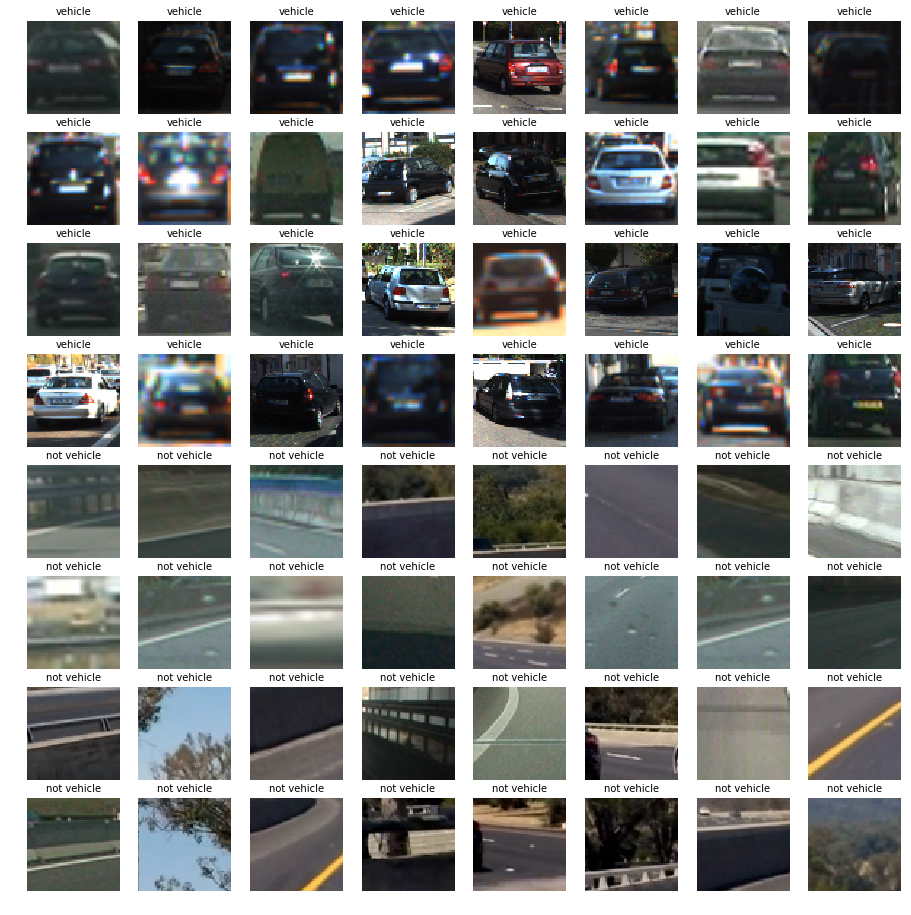

In [18]:
car_images, noncar_images = import_images()
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list of test images with cars and no cars
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('vehicle', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not vehicle', fontsize=10)
    axs[i].imshow(img)
plt.show()

## Visualize result of the HOG function by using test images

Number of Car images = 8792
Number of Not-Car images = 8792


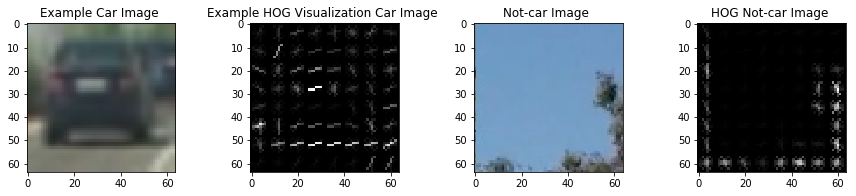

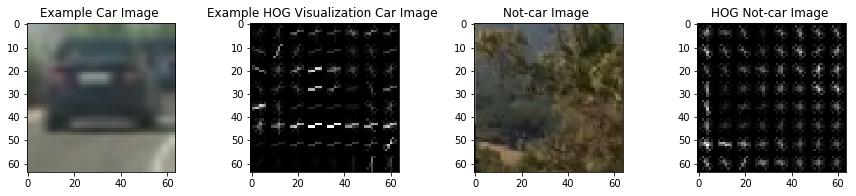

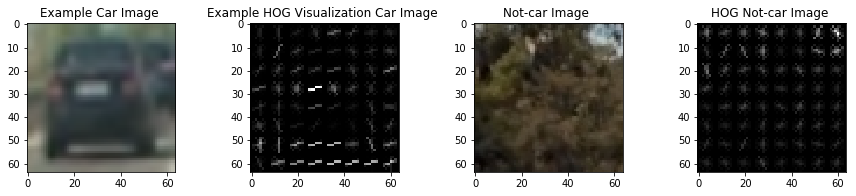

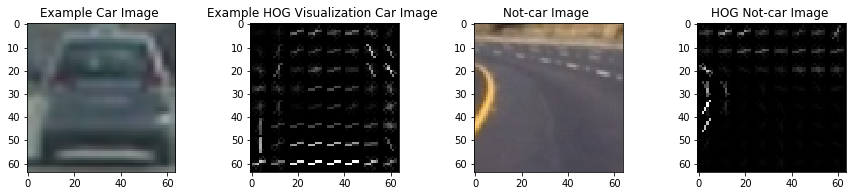

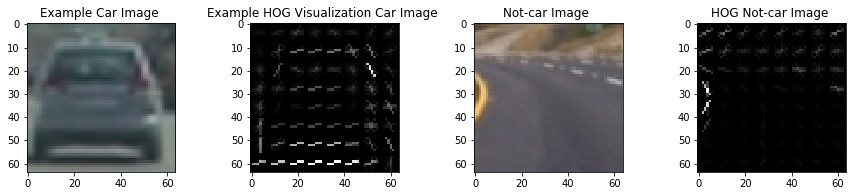

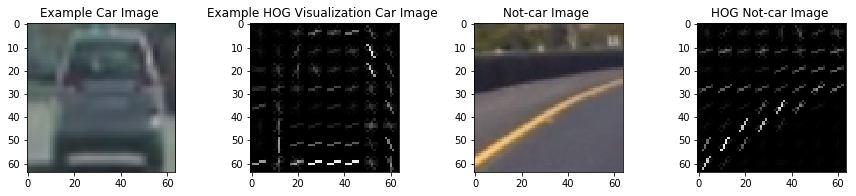

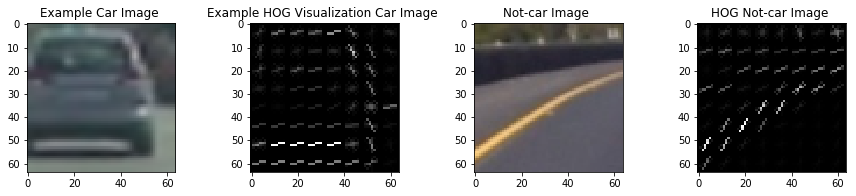

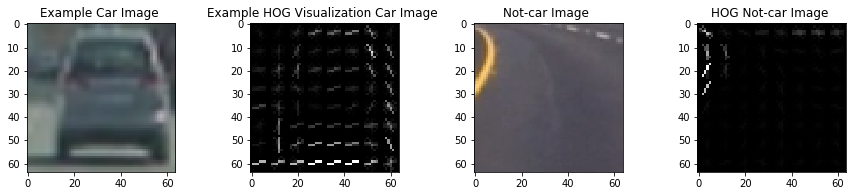

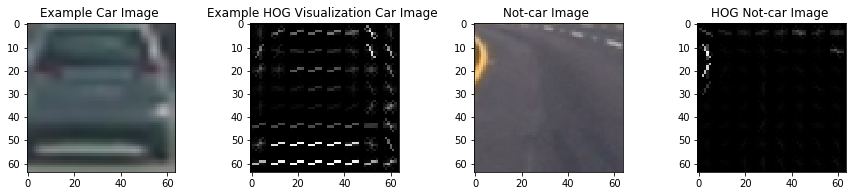

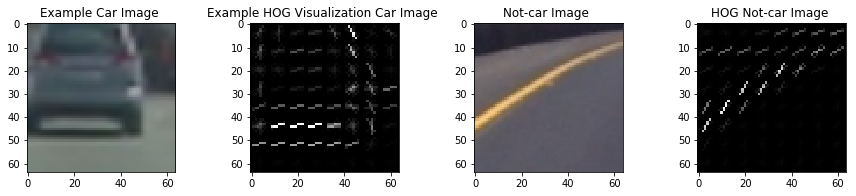

In [84]:
# Define a function to return HOG features and visualization
def get_hog_features_test(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

car_images, noncar_images = import_images()
for i in range(10):
    car_image = mpimg.imread(car_images[i])
    notcar_image = mpimg.imread(noncar_images[i])
    
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    gray_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
    gray_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
    
    # Call our function with vis=True to see an image output
    features, hog_car_image = get_hog_features_test(gray_car_image, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    features, hog_notcar_image = get_hog_features_test(gray_notcar_image, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

    # Plot the examples
    fig = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(car_image)
    plt.title('Example Car Image ' + car_images[i][34:-5])
    plt.subplot(142)
    plt.imshow(hog_car_image, cmap='gray')
    plt.title('Example HOG Visualization Car Image ' + car_images[i][34:-5])
    
    plt.subplot(143)
    plt.imshow(notcar_image)
    plt.title('Not-car Image ' + noncar_images[i][41:-5])
    plt.subplot(144)
    plt.imshow(hog_notcar_image, cmap='gray')
    plt.title('HOG Not-car Image ' + noncar_images[i][41:-5])
    fig.tight_layout()
plt.show()

## Extract color histogram features and bin spacial features and put them togather by doing concatanation of two arrays

Number of Car images = 8792
Number of Not-Car images = 8792


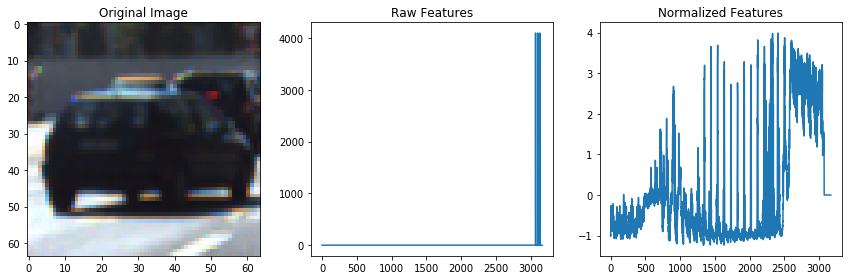

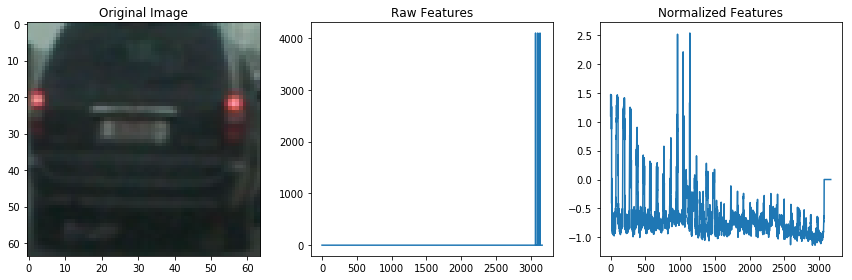

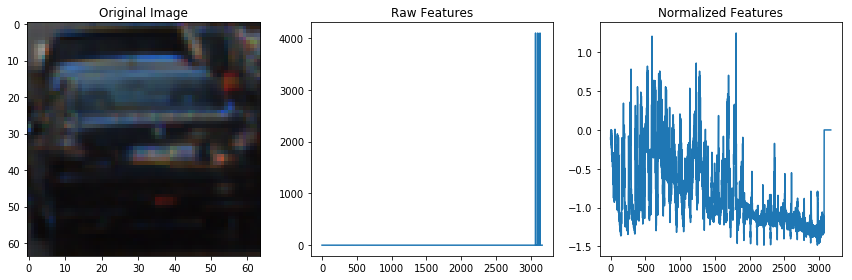

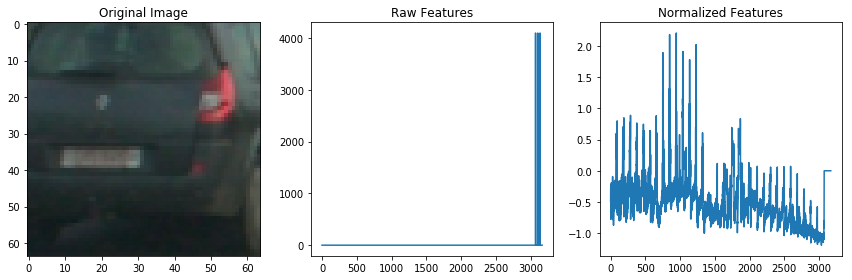

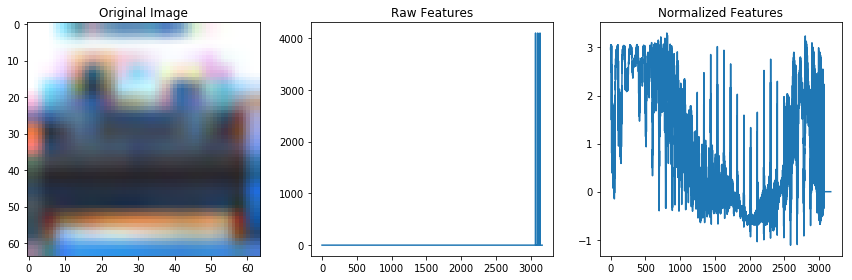

In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

car_images, noncar_images = import_images()
        
car_features = extract_features(car_images, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(noncar_images, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

for i in range(5):
    fig = plt.figure(figsize=(12,4))
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
plt.show()

## Draw boxes on car image

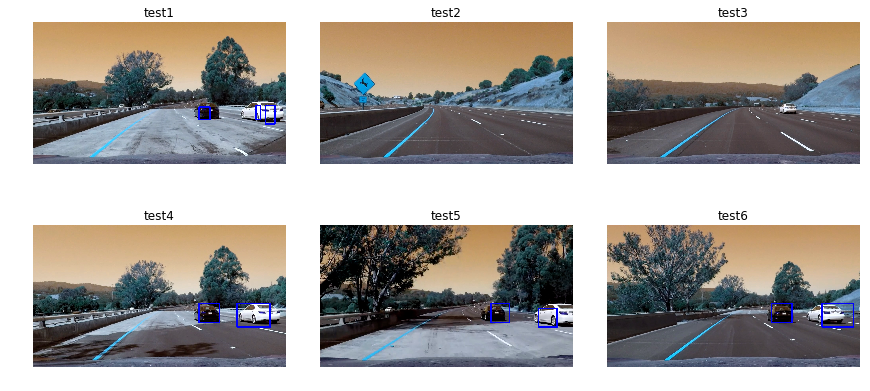

In [74]:
test_images = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list of test images, find cars and draw boxes on the image
for i in np.arange(len(test_images)):
    img = cv2.imread(test_images[i])
    window_img = process_image(img)
    axs[i].axis('off')
    axs[i].set_title(test_images[i][12:-4], fontsize=12)
    axs[i].imshow(window_img)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Show heat on image

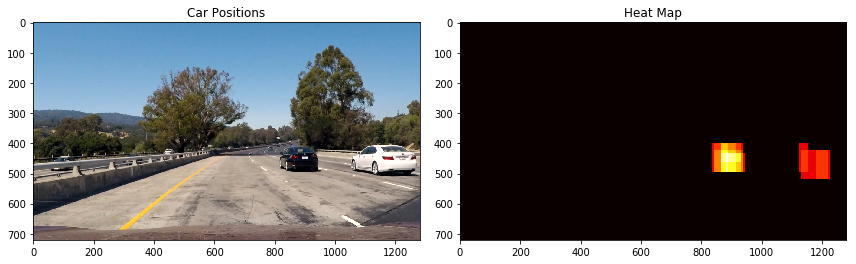

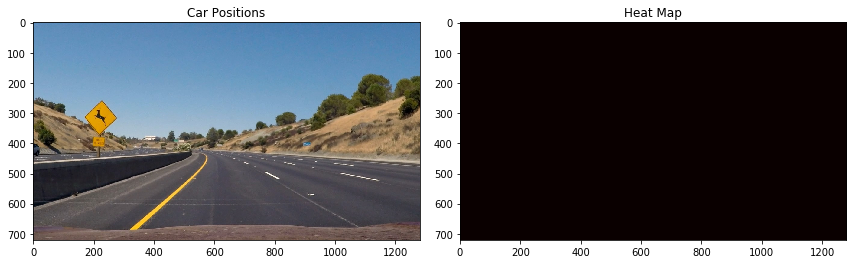

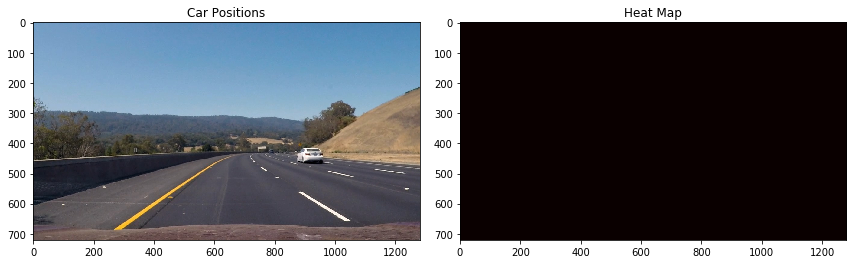

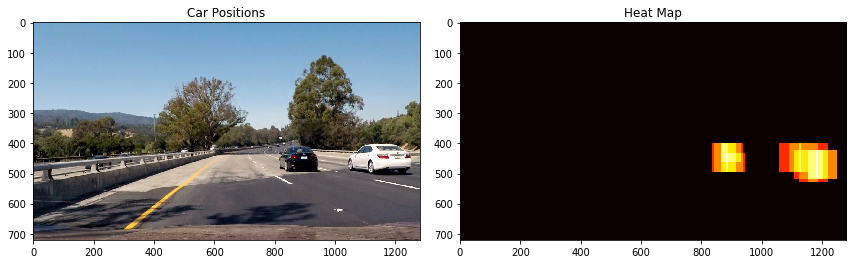

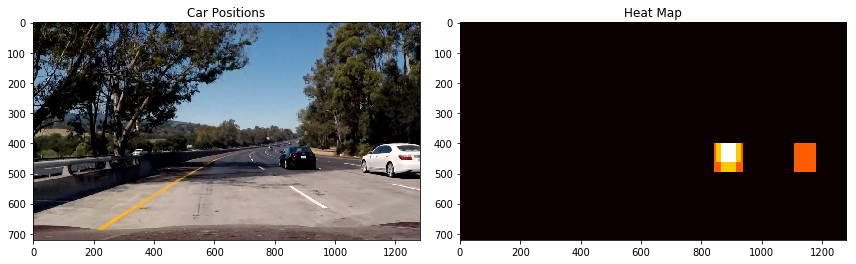

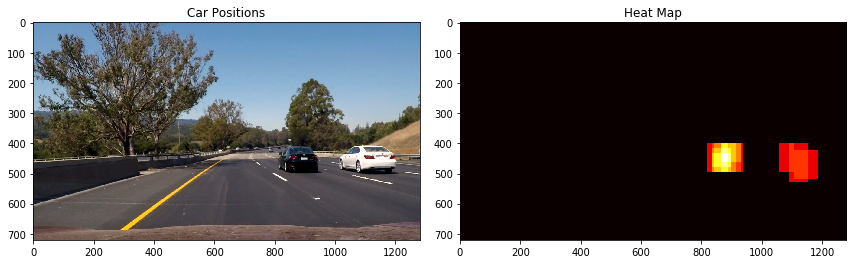

In [83]:
dist_pickle = import_data()
color_space = dist_pickle["color_space"]
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hog_channel = dist_pickle["hog_channel"]
hist_bins = dist_pickle["hist_bins"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

x_start_stop = [None, None]
xy_overlap = (0.75, 0.75)

y_start_stops = [[400, 645], [400, 600], [400, 550]]
xy_windows = [(128, 128), (96, 96), (64, 64)]

for img in test_images:
    # Read in image similar to one shown above 
    image = mpimg.imread(img)
    window_image = np.copy(image)
    image = image.astype(np.float32)/255
    windows = []

    for y_start_stop, xy_window in zip(y_start_stops, xy_windows):
        windows.extend(slide_window(image, x_start_stop, y_start_stop, xy_window, xy_overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler,
                    color_space='YCrCb', spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, hog_channel=hog_channel,
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
plt.show()

## Example of labels

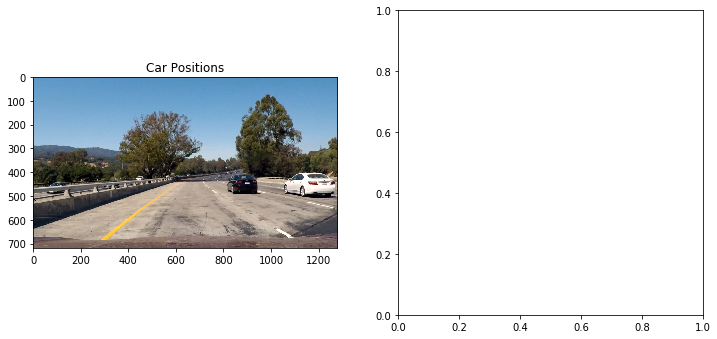

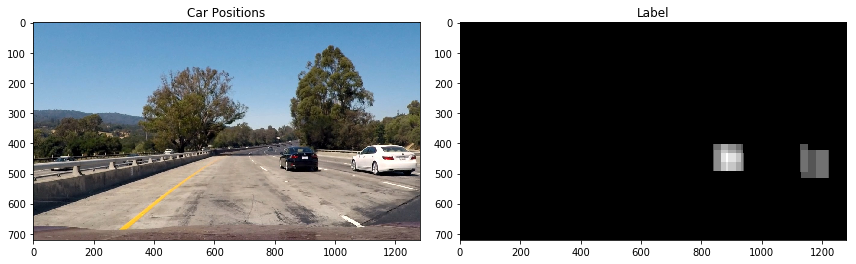

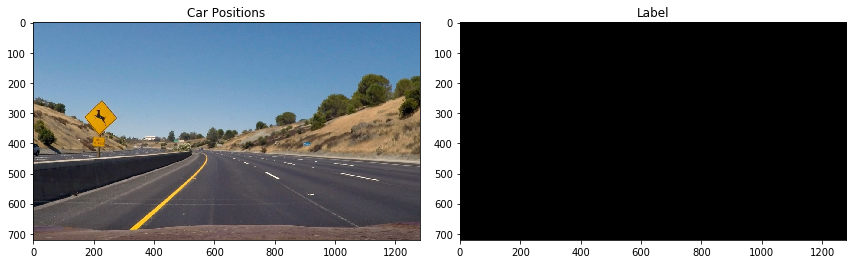

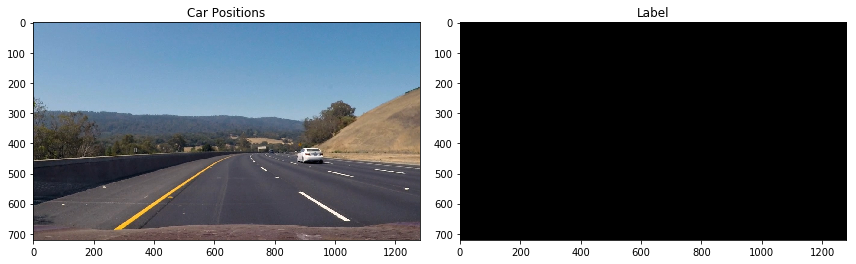

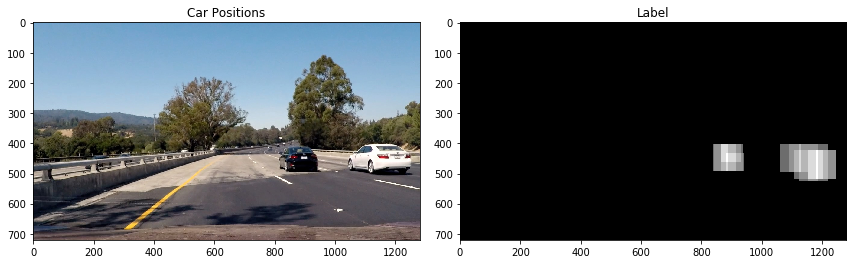

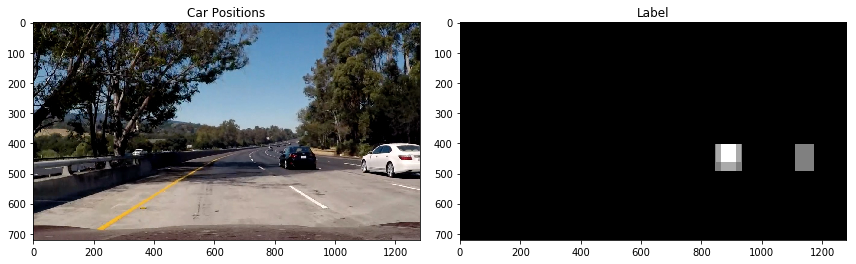

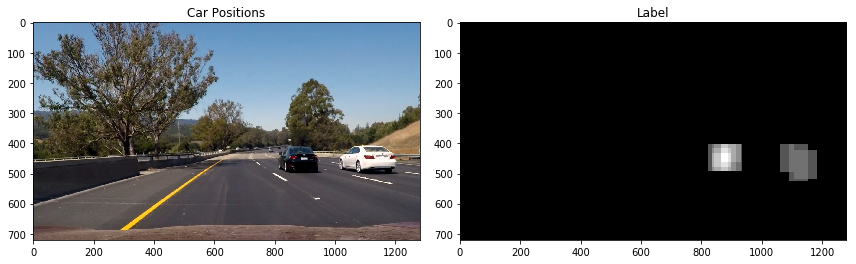

In [90]:
dist_pickle = import_data()
color_space = dist_pickle["color_space"]
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hog_channel = dist_pickle["hog_channel"]
hist_bins = dist_pickle["hist_bins"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

x_start_stop = [None, None]
xy_overlap = (0.75, 0.75)

y_start_stops = [[400, 645], [400, 600], [400, 550]]
xy_windows = [(128, 128), (96, 96), (64, 64)]

for img in test_images:
    # Read in image similar to one shown above 
    image = mpimg.imread(img)
    window_image = np.copy(image)
    image = image.astype(np.float32)/255
    windows = []

    for y_start_stop, xy_window in zip(y_start_stops, xy_windows):
        windows.extend(slide_window(image, x_start_stop, y_start_stop, xy_window, xy_overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler,
                    color_space='YCrCb', spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, hog_channel=hog_channel,
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(heatmap), labels)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(draw_img, cmap='gray')
    plt.title('Label')
    fig.tight_layout()
plt.show()